## To do

- prefer to find better term than "intermediate", as clearly gamb_colu rather than arab. 
- better colour than grey
- tidy up offsets based on new text_va logic

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import seaborn as sns
import gcsfs
from pathlib import Path
import yaml
import dask.array as da
from ag3 import release_data
v3_release = release_data()
#cartopy text scale issues
sns.set_context('paper', font_scale=.9)

cartopy 0.17.0


### setup data

In [2]:
#samplesets
samplesets = v3_release.all_wild_sample_sets

In [3]:
samplesets

['AG1000G-AO',
 'AG1000G-BF-A',
 'AG1000G-BF-B',
 'AG1000G-BF-C',
 'AG1000G-CD',
 'AG1000G-CF',
 'AG1000G-CI',
 'AG1000G-CM-A',
 'AG1000G-CM-B',
 'AG1000G-CM-C',
 'AG1000G-FR',
 'AG1000G-GA-A',
 'AG1000G-GH',
 'AG1000G-GM-A',
 'AG1000G-GM-B',
 'AG1000G-GM-C',
 'AG1000G-GN-A',
 'AG1000G-GN-B',
 'AG1000G-GQ',
 'AG1000G-GW',
 'AG1000G-KE',
 'AG1000G-ML-A',
 'AG1000G-ML-B',
 'AG1000G-MW',
 'AG1000G-MZ',
 'AG1000G-TZ',
 'AG1000G-UG']

In [4]:
all_meta = v3_release.load_sample_set_metadata(samplesets, True)
all_meta.sample_set.value_counts()

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


AG1000G-CM-A    303
AG1000G-TZ      300
AG1000G-UG      290
AG1000G-GN-B    185
AG1000G-BF-A    181
AG1000G-GM-C    174
AG1000G-BF-B    102
AG1000G-GW      101
AG1000G-GH      100
AG1000G-CM-B     97
AG1000G-KE       86
AG1000G-AO       81
AG1000G-CI       80
AG1000G-CD       76
AG1000G-MZ       74
AG1000G-GM-A     74
AG1000G-CF       73
AG1000G-ML-B     71
AG1000G-GA-A     69
AG1000G-ML-A     60
AG1000G-GN-A     45
AG1000G-CM-C     44
AG1000G-MW       41
AG1000G-GM-B     31
AG1000G-FR       23
AG1000G-BF-C     13
AG1000G-GQ       10
Name: sample_set, dtype: int64

In [5]:
all_meta.country = all_meta.country.str.replace("Gambia, The", "The Gambia").str.replace("Equatorial Guinea", "Bioko")

In [6]:
df_centroids = pd.read_csv("../data/Africa_centroids.csv", index_col=0).rename(str.lower, axis=1)

In [7]:
sampleset_by_country = pd.crosstab(all_meta.sample_set, all_meta.country)
# any samplesets that have multiple countries? 
sampleset_by_country.loc[(sampleset_by_country > 0).sum(axis=1) > 1]

country,Angola,Bioko,Burkina Faso,Cameroon,Central African Republic,Cote d'Ivoire,Democratic Republic of Congo,Gabon,Ghana,Guinea,Guinea-Bissau,Kenya,Malawi,Mali,Mayotte,Mozambique,Tanzania,The Gambia,Uganda
sample_set,,,,,,,,,,,,,,,,,,,
AG1000G-GN-B,0,0,0,0,0,0,0,0,0,91,0,0,0,94,0,0,0,0,0


### plotting

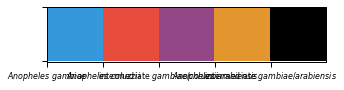

In [8]:
#countries
countries = list(all_meta.country.unique())
#long species labels
sp_nm = ['$Anopheles$ $gambiae$', '$Anopheles$ $coluzzii$',  'intermediate $gambiae$/$coluzzii$','$Anopheles$ $arabiensis$', 'intermediate $gambiae$/$arabiensis$']
#palette
flat = ["#3498db", "#e74c3c", "#944786", "#e2962d", "#000000"]
palette = sns.color_palette(flat, n_colors=len(sp_nm))
# add a colour for other_resistant
sns.palplot(palette)
plt.gca().set_xticklabels(sp_nm);

In [9]:
#build df with lat lon offsets and country labels - two letter codes?
offset_df = pd.DataFrame(index=countries, columns=["offset_lon", "offset_lat"], data=0.0)

In [10]:
offset_df.loc['Angola'] = 0, 1
offset_df.loc['Burkina Faso'] = 2, 0
offset_df.loc['Cameroon'] = -0.3, 1
offset_df.loc['Central African Republic'] = 0.3, 1
offset_df.loc["Cote d'Ivoire"] = -0.5, 0
offset_df.loc['Democratic Republic of Congo'] = 0, 3
offset_df.loc['Bioko'] = -3, -1.5
offset_df.loc['The Gambia'] = -4, 1
offset_df.loc['Ghana'] = 0.4, -1.5
offset_df.loc['Guinea-Bissau'] = -2.5, -3
offset_df.loc['Kenya'] = 0, 1
offset_df.loc['Malawi'] = -1, 0
offset_df.loc['Mali'] = 0, -1
offset_df.loc['Mayotte'] = -1, 3
offset_df.loc['Mozambique'] = 1, -2
offset_df.loc['Tanzania'] = 0, 1
offset_df.loc['Uganda'] = 0, 1

In [11]:
alternate_names = {
#     "Equatorial Guinea": "Bioko",
#     "Gambia, The": "The Gambia",
    "Central African Republic": "Central African Republic".replace(" ", "\n"),
    "Democratic Republic of Congo": "Democratic\nRepublic\nof Congo",
    "Mayotte":"Mayotte island".replace(" ", "\n"),
    "Bioko": "Bioko island".replace(" ", "\n"),
    "Cote d'Ivoire": "Cote d'Ivoire".replace(" ", "\n"),
    "The Gambia": "The Gambia".replace(" ", "\n")
}

In [12]:
label_locations = {
    c: "bottom" for c in ['Ghana', 'Guinea-Bissau', 'Gabon', 'Bioko', 'Kenya', 'Angola', 'Tanzania', 'Malawi', 'Mozambique', 'Burkina Faso', 'Democratic Republic of Congo', "Cote d'Ivoire"]}
label_locations

{'Ghana': 'bottom',
 'Guinea-Bissau': 'bottom',
 'Gabon': 'bottom',
 'Bioko': 'bottom',
 'Kenya': 'bottom',
 'Angola': 'bottom',
 'Tanzania': 'bottom',
 'Malawi': 'bottom',
 'Mozambique': 'bottom',
 'Burkina Faso': 'bottom',
 'Democratic Republic of Congo': 'bottom',
 "Cote d'Ivoire": 'bottom'}

In [13]:
arab_call = pd.crosstab(all_meta.country, all_meta.species_gambcolu_arabiensis)
colu_call = pd.crosstab(all_meta.country, all_meta.species_gambiae_coluzzii)
colu_call.rename({"intermediate": "gambaie/coluzzii"}, axis=1, inplace=True)

In [14]:
summary_counts = pd.concat([arab_call, colu_call], axis=1, sort=False).fillna(0).astype(int)
summary_counts.drop("gamb_colu", axis=1, inplace=True)

In [15]:
summary_counts.head()

,arabiensis,intermediate,coluzzii,gambiae,gambaie/coluzzii
Angola,0,0,81,0,0
Bioko,0,0,0,10,0
Burkina Faso,3,0,135,157,1
Cameroon,2,0,26,416,0
Central African Republic,0,0,18,55,0


In [16]:
ar, it, cl, ga, gc = summary_counts.loc["Uganda"]
ar, it, cl, ga, gc

(82, 1, 0, 207, 0)

In [17]:
#code to get a single averaged lat/lon and species composition for each country
def plot_pyr_map(dpi=150, extent=[-23, 48, -20, 17.5], figsize=(8, 4), label_fontsize=7):
    
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=dpi)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=0.7, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=5)
    
    for c in countries:
        
        ar, it, cl, gm, gc = summary_counts.loc[c]
        
        #use centroids for countries +- offsets
        offset_lon = offset_df.loc[c].offset_lon
        offset_lat = offset_df.loc[c].offset_lat
        
        lon = df_centroids.loc[c].longitude
        lat = df_centroids.loc[c].latitude

        centre = (lon + offset_lon, lat + offset_lat)
        radius = np.sqrt(summary_counts.loc[c].sum() * .02)
        text_offset = (radius + (0.1 * radius))
        
        ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=1))
        ax.pie([gm, cl, gc, ar, it], wedgeprops=dict(zorder=7), colors=palette, center=centre, radius=radius, shadow=True)
        
        # assume we want label above the pie unless otherwise specified
        # if we want the text to appear _below_ the pie- we need to:
        # substract radius etc (text_offset)
        # set the text vertical alignment to "top"
        
        # otherwise... 
        # the vertical offset should be positive
        # the va should be "bottom"
        
        text_pos = label_locations.get(c, "top")
        text_va = "bottom"
        
        # text_va is therefore bottom if top, and top if bottom.
        if text_pos == "bottom":
            text_va = "top"
            text_offset = -text_offset
        
        long_label = alternate_names.get(c, c)
        
        ax.text(
            centre[0], 
            centre[1] + text_offset, 
            long_label, 
            ha='center', 
            va=text_va,
            fontsize=6, 
            fontweight='bold', 
            bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=.8, ), 
            zorder=6)
        
        # plot a line if there is an offset
        if offset_lat != 0 or offset_lon != 0:
            ax.plot([lon, lon + offset_lon],[lat, lat + offset_lat], 'k-', lw=1, zorder=5)
            
        
   # manual colour legend
    plt.text(-14.0, -1.3, 'Species', fontsize=7,fontweight='bold')
    
    plt.plot([-17.5, -20.6],[-3.9, -3.9], color=flat[0], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-4.5,  sp_nm[0], fontsize=7 )

    plt.plot([-17.5, -20.6],[-6.4, -6.4], color=flat[1], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-7, sp_nm[1], fontsize=7 )
    
    plt.plot([-17.5, -20.6],[-9.0, -9.0], color=flat[2], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-9.55, sp_nm[2], fontsize=7 )
    
    plt.plot([-17.5, -20.6],[-11.6, -11.6], color=flat[3], lw=7, zorder=20, solid_capstyle='round')
    plt.text(-15.5,-12.1, sp_nm[3], fontsize=7 )
    
    plt.text(-17,-16.5, '   Sample size', fontsize=7,fontweight='bold')
    #cover tiny islands
    plt.plot([-17, -15],[-6.5, -6.5], 'w', lw=20, zorder=3)
    plt.plot([-6.5, -6],[-15, -15], 'w', lw=20, zorder=3)      

    #X0,X1,Y0,Y1  extent format  
    ax.set_extent(extent) 
    
    #size legend
    l1 = Line2D([], [], marker = 'o', markersize=11, markerfacecolor='k',  color='w') 
    l2 = Line2D([], [], marker = 'o', markersize=20, markerfacecolor='k',  color='w') 
    l3 = Line2D([], [], marker = 'o', markersize=32, markerfacecolor='k',  color='w')
    labelz = ["n=50", " n=150", "   n=300"]   
    leg = ax.legend([l1, l2, l3], labelz, ncol=3, frameon=False, fontsize=7,handlelength=2.1, loc = 3,
                     borderpad = 1.6, handletextpad=0.6, bbox_to_anchor=(-0.025, 0.0))
    # If format is not set, then the output format is inferred from the extension of fname, if any, and from rcParams["savefig.format"] = 'png' otherwise.
    #fig.savefig('../content/artwork/collection_map.svg', dpi=dpi, bbox_inches='tight');
    return ax

/opt/conda/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/opt/conda/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


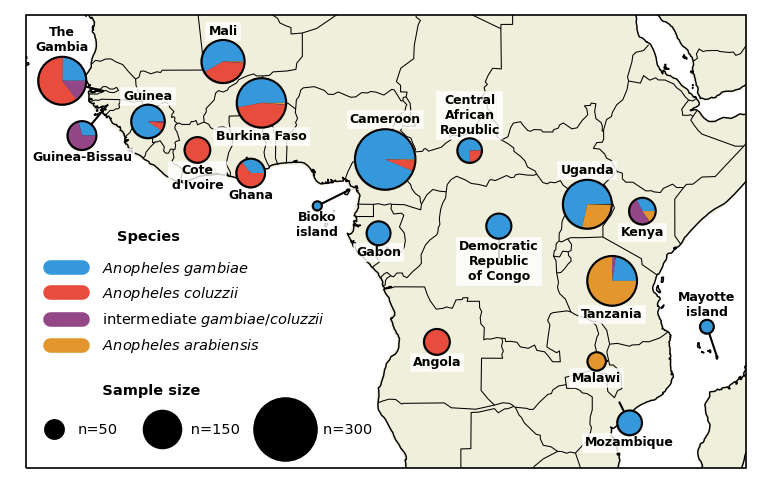

In [18]:
a = plot_pyr_map()

# Separate panel "region" plots

In [19]:
#sites dictionary
site_dict = {'Western' : ['Mali', 'Burkina Faso', "Cote d'Ivoire", 'Ghana', 'Guinea', 'Guinea-Bissau', 'The Gambia']
            , 'Central' : ['Central African Republic', 'Democratic Republic of Congo', 'Cameroon', 'Bioko', 'Gabon', 'Angola']
            , 'Eastern' : ['Uganda', 'Kenya', 'Tanzania', 'Malawi', 'Mozambique', 'Mayotte']}

In [20]:
#consolidate all Mayotte sites into one (so we get a pie chart)
all_meta.loc[(all_meta.country == 'Mayotte'),'latitude'] = all_meta[all_meta.country == 'Mayotte'].latitude.mean()
all_meta.loc[(all_meta.country == 'Mayotte'),'longitude'] = all_meta[all_meta.country == 'Mayotte'].longitude.mean()
all_meta[all_meta.country == 'Mayotte'].head()

,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,sample_set,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,is_arabiensis,is_gamb_colu,is_gambiae,is_coluzzii
sample_id,,,,,,,,,,,,,,,,,,
AP0007-C,60,Igor Sharakhov,Mayotte,Mtsamboro Forest Reserve,2011,-1,-12.857087,45.137435,F,AG1000G-FR,0.035,0.003,gamb_colu,gambiae,False,True,True,False
AP0021-C,92,Igor Sharakhov,Mayotte,Karihani Lake,2011,-1,-12.857087,45.137435,F,AG1000G-FR,0.034,0.003,gamb_colu,gambiae,False,True,True,False
AP0019-C,88,Igor Sharakhov,Mayotte,Mtsanga Charifou,2011,-1,-12.857087,45.137435,M,AG1000G-FR,0.039,0.003,gamb_colu,gambiae,False,True,True,False
AP0020-C,78,Igor Sharakhov,Mayotte,Mtsanga Charifou,2011,-1,-12.857087,45.137435,M,AG1000G-FR,0.039,0.003,gamb_colu,gambiae,False,True,True,False
AP0009-C,62,Igor Sharakhov,Mayotte,Combani,2011,-1,-12.857087,45.137435,M,AG1000G-FR,0.038,0.003,gamb_colu,gambiae,False,True,True,False


In [21]:
#counts by sites
df_site_counts = all_meta.groupby(['latitude', 'longitude', 'country']).size().reset_index(name='counts')
df_site_counts['site'] = range(len(df_site_counts))
df_site_counts.sort_values('counts')

,latitude,longitude,country,counts,site
76,9.703,13.859,Cameroon,1,76
45,6.915,13.132,Cameroon,1,45
78,9.765,13.950,Cameroon,1,78
25,4.166,11.535,Cameroon,1,25
59,8.476,13.644,Cameroon,1,59
...,...,...,...,...,...
28,4.341,13.558,Cameroon,110,28
97,11.233,-4.472,Burkina Faso,128,97
7,-1.962,31.651,Tanzania,170,7
116,13.567,-14.917,The Gambia,174,116


In [22]:
#our >= 20 sites 
df_20 = df_site_counts[df_site_counts.counts >= 10].copy()
len(df_20),len(df_20.latitude.unique()),len(df_20.longitude.unique())

(43, 43, 42)

In [23]:
#new full meta but only containing 20 sites (to preserve all species columns)
all_20_meta = all_meta.merge(df_20[['longitude','latitude', 'site']])
len(all_20_meta.latitude.unique()),len(all_20_meta.longitude.unique())

(43, 42)

In [24]:
#summary species counts for >20 sites
arab_call = pd.crosstab(all_20_meta.site, all_20_meta.species_gambcolu_arabiensis)
colu_call = pd.crosstab(all_20_meta.site, all_20_meta.species_gambiae_coluzzii)
colu_call.rename({"intermediate": "gambiae/coluzzii"}, axis=1, inplace=True)
summary_20_counts = pd.concat([arab_call, colu_call], axis=1, sort=False).fillna(0).astype(int)
summary_20_counts.drop("gamb_colu", axis=1, inplace=True)
summary_20_counts.head()

,arabiensis,intermediate,coluzzii,gambiae,gambiae/coluzzii
site,,,,,
0,0,0,0,74,0
1,41,0,0,0,0
2,0,0,0,23,0
3,0,0,81,0,0
4,1,0,0,36,6


In [25]:
#get the centroids for the countries we sample in - use this as starting point for country labels?
df_p3_centroids = df_centroids[df_centroids.index.isin(countries)].reset_index().copy()
df_p3_centroids['offset_lat'] = 0.0
df_p3_centroids['offset_lon'] = 0.0
#Ghana
df_p3_centroids.loc[8, 'offset_lat'] = 1.0
df_p3_centroids.loc[8, 'offset_lon'] = 0.2
#Cote
df_p3_centroids.loc[4, 'offset_lat'] = -1.0
#guinea
df_p3_centroids.loc[9, 'offset_lon'] = -1.2
#Mali
df_p3_centroids.loc[13, 'offset_lat'] = -2.0
#Guinea Bissau
df_p3_centroids.loc[11, 'offset_lat'] = -4.5
df_p3_centroids.loc[11, 'offset_lon'] = -1.2
#Burkina
df_p3_centroids.loc[1, 'offset_lon'] = 0.5
#The Gambia
df_p3_centroids.loc[10, 'offset_lat'] = 3.5
df_p3_centroids.loc[10, 'offset_lon'] = -1.0
df_p3_centroids

,name_long,pop_est,gdp_md_est,lastcensus,longitude,latitude,offset_lat,offset_lon
0,Angola,12799293,110300.0,1970,17.537368,-12.293361,0.0,0.0
1,Burkina Faso,15746232,17820.0,2006,-1.754566,12.269538,0.0,0.5
2,Bioko,334463,NaN,2015,8.749618,3.616311,0.0,0.0
3,Central African Republic,4511488,3198.0,2003,20.468268,6.568233,0.0,0.0
4,Cote d'Ivoire,20617068,33850.0,1998,-5.569216,7.628426,-1.0,0.0
5,Cameroon,18879301,42750.0,2005,12.739642,5.691098,0.0,0.0
6,Democratic Republic of Congo,68692542,20640.0,1984,23.643961,-2.877463,0.0,0.0
7,Gabon,1514993,21110.0,2003,11.788629,-0.586600,0.0,0.0
8,Ghana,23832495,34200.0,2010,-1.216766,6.853456,1.0,0.2
9,Guinea,10057975,10600.0,1996,-10.940666,10.436216,0.0,-1.2


In [26]:
alternate_names = {
    "Central African Republic": "Central African Republic".replace(" ", "\n"),
    "Democratic Republic of Congo": "Democratic\nRepublic\nof Congo",
    "Mayotte":"Mayotte island".replace(" ", "\n"),
    "Bioko": "Bioko island".replace(" ", "\n"),
    "Cote d'Ivoire": "Cote d'Ivoire".replace(" ", "\n"),
    "Guinea-Bissau": "Guinea- Bissau".replace(" ", "\n"),
    "Burkina Faso": "Burkina Faso".replace(" ", "\n")
}

# TODO - offsets!

In [27]:
df_20.set_index('site', inplace=True)

In [61]:
df_20['offset_lat'] = 0.0
df_20['offset_lon'] = 0.0
#The Gambia
df_20.loc[113, 'offset_lat'] = 0.6
df_20.loc[113, 'offset_lon'] = -2.0
df_20.loc[114, 'offset_lat'] = 2
df_20.loc[114, 'offset_lon'] = -1.0
df_20.loc[117, 'offset_lat'] = 2.0
df_20.loc[117, 'offset_lon'] = 1.0
df_20.loc[116, 'offset_lat'] = 1.0
df_20.loc[116, 'offset_lon'] = 1.7

#Guinea Bissau
df_20.loc[101, 'offset_lat'] = -2.0
df_20.loc[101, 'offset_lon'] = 0.6
df_20.loc[102, 'offset_lat'] = -1.7
df_20.loc[102, 'offset_lon'] = -1.5

#Guinea
df_20.loc[72, 'offset_lat'] = -1.0
df_20.loc[72, 'offset_lon'] = -1.5
df_20.loc[60, 'offset_lat'] = -1.5
df_20.loc[60, 'offset_lon'] = -0.5

#Cote d'Ivoire
df_20.loc[39, 'offset_lat'] = -1.8
df_20.loc[39, 'offset_lon'] = 0.0

#Ghana
df_20.loc[31, 'offset_lat'] = -1.5
df_20.loc[31, 'offset_lon'] = -0.3
df_20.loc[34, 'offset_lat'] = -1.5
df_20.loc[34, 'offset_lon'] = 1.5
df_20.loc[35, 'offset_lat'] = -0.5
df_20.loc[35, 'offset_lon'] = 2.0
df_20.loc[40, 'offset_lat'] = 1.0
df_20.loc[40, 'offset_lon'] = 1.5

#Burkina Faso
df_20.loc[98, 'offset_lat'] = -1.5
df_20.loc[98, 'offset_lon'] = -1.4
df_20.loc[97, 'offset_lat'] = -2.0
df_20.loc[97, 'offset_lon'] = 0.5
df_20.loc[96, 'offset_lat'] = -1.0
df_20.loc[96, 'offset_lon'] = 2.0
df_20.loc[103, 'offset_lat'] = -1.0
df_20.loc[103, 'offset_lon'] = 2.0

#Mali
df_20.loc[95, 'offset_lat'] = -0.5
df_20.loc[95, 'offset_lon'] = -2.0
df_20.loc[99, 'offset_lat'] = 0.5
df_20.loc[99, 'offset_lon'] = -2.0
df_20.loc[100, 'offset_lon'] = 2.0
df_20.loc[100, 'offset_lat'] = 0.2
df_20.loc[109, 'offset_lat'] = 1.0
df_20.loc[109, 'offset_lon'] = -2.0
df_20.loc[110, 'offset_lon'] = 0.0
df_20.loc[110, 'offset_lat'] = 2.0
df_20.loc[112, 'offset_lon'] = 2.0
df_20.loc[112, 'offset_lat'] = 1.0
df_20


,latitude,longitude,country,counts,offset_lat,offset_lon
site,,,,,,
0,-23.716000,35.299000,Mozambique,74,0.0,0.0
1,-15.933000,34.755000,Malawi,41,0.0,0.0
2,-12.857087,45.137435,Mayotte,23,0.0,0.0
3,-8.884000,13.302000,Angola,81,0.0,0.0
4,-4.940000,38.948000,Tanzania,43,0.0,0.0
5,-3.511000,39.909000,Kenya,86,0.0,0.0
6,-3.482000,37.308000,Tanzania,40,0.0,0.0
7,-1.962000,31.651000,Tanzania,170,0.0,0.0
8,-1.431000,34.199000,Tanzania,47,0.0,0.0


In [70]:
def plot_pyr_map_panel(dpi=150, extent=[-23, 48, -20, 17.5], figsize=(8, 4), label_fontsize=7, region='Western', fn=None, country=True, scale=False):
    
    subplot_kw = dict(projection=ccrs.PlateCarree())
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=subplot_kw, dpi=dpi)
    ax.add_feature(cfeature.LAND, linewidth=1, zorder=1)
    ax.coastlines(resolution='50m', linewidth=0.7, zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
    
    df_region_site_counts = df_site_counts[df_site_counts['country'].isin(site_dict[region])]
    
    for _, row in df_region_site_counts.iterrows():
        lon = row['longitude']
        lat = row['latitude']
        site = row['site']
        size = row['counts']
        
        if size < 10:
            centre = (lon, lat)
            ax.add_patch(plt.Circle(xy=centre, radius=0.2, facecolor='w', edgecolor='r', zorder=4, lw=1))
        if size >= 10:
            offset_lon = df_20.loc[site].offset_lon
            offset_lat = df_20.loc[site].offset_lat
            centre = (lon + offset_lon, lat + offset_lat)
            if not scale:
                radius = 0.7
            else:
                radius = np.sqrt(size * .01)
            ar, it, cl, gm, gc = summary_20_counts.loc[site]
            ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='r', edgecolor='k', zorder=3, lw=1.5))
            ax.pie([gm, cl, gc, ar, it], wedgeprops=dict(zorder=7), colors=palette, center=centre, radius=radius, shadow=True)
            
            # plot a line if there is an offset
            if offset_lat != 0 or offset_lon != 0:
                ax.plot([lon, lon + offset_lon],[lat, lat + offset_lat], 'k-', lw=1, zorder=5)
            


    #country labels
    if country == True:
        df_region_centroids = df_p3_centroids[df_p3_centroids['name_long'].isin(site_dict[region])]
        for _, row in df_region_centroids.iterrows():
            lon = row['longitude'] + row['offset_lon']
            lat = row['latitude'] + row['offset_lat']
            c = row.name_long
            long_label = alternate_names.get(c, c)
            plt.text(lon, lat, long_label, fontsize=6, ha='center', bbox=dict(edgecolor='none', facecolor='w', pad=1, alpha=.7, ))

    ax.set_extent(extent) 
    ax.set_title(region)
    if fn:
        fig.savefig(fn, dpi=dpi, bbox_inches='tight');
    return ax

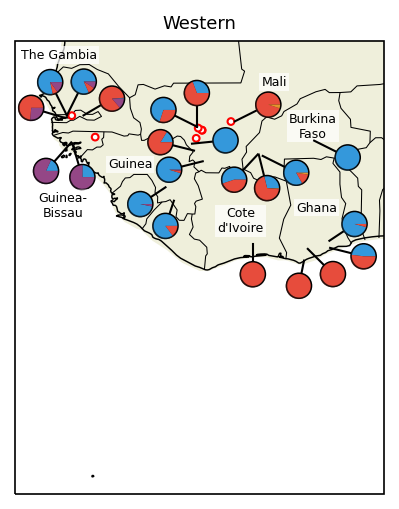

In [71]:
b = plot_pyr_map_panel(extent=[-19, 3, -9, 18], region='Western', country=True, fn='../content/images/western_map_country.svg')

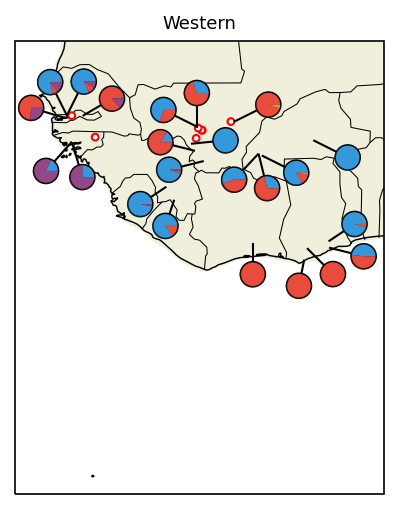

In [72]:
b = plot_pyr_map_panel(extent=[-19, 3, -9, 18], region='Western', country=False, fn='../content/images/western_map.svg')

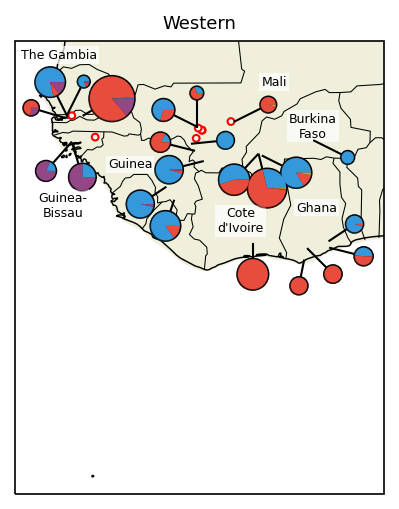

In [73]:
b = plot_pyr_map_panel(extent=[-19, 3, -9, 18], region='Western', country=True, scale=True, fn='../content/images/western_map_scale.svg')

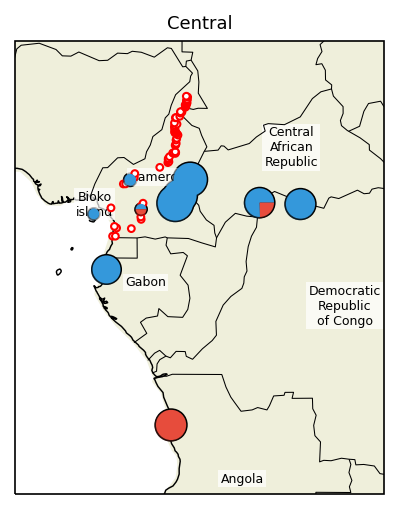

In [74]:
c = plot_pyr_map_panel(extent=[4, 26, -13, 14],region='Central', scale=True, country=True)

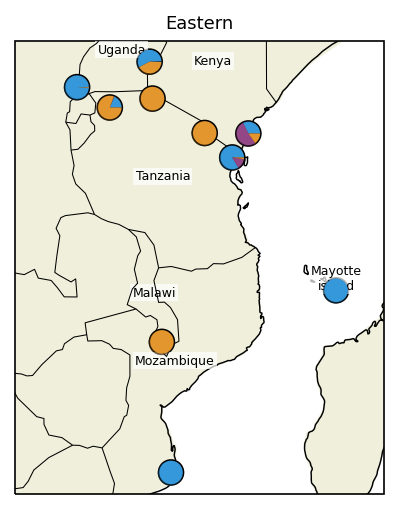

In [32]:
d = plot_pyr_map_panel(extent=[26, 48, -25, 2], region='Eastern')

# to do
- look at scaling pies
- <10 dot colour - tried grey centre but then that makes me want to fix the overplotting more
- if sites are so close that they overlap (this is a different distance for small/large sites) then move them so they don't and add arrows
- legends in lower WESTERN plot - <20, >=20, species colour
- final job is position of country names (or country codes) - currently placed with centroids - fix island names
- clean up code e.g. extent can be baked in - call by region